# [EDA] Spatial Contexts for Los Angeles

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## CalEPA Data

### GeoPandas DataFrame of LA County

In [15]:
# Original Pandas df of Los Angeles 
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0)

In [16]:
# Convert to GeoPandas with coordinates (longitude, latitude)
gpd_la = gpd.GeoDataFrame(ces_la, geometry=gpd.points_from_xy(ces_la.Longitude, ces_la.Latitude))

In [17]:
gpd_la.head()

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%),geometry
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100% (highest scores),0.048,...,13.34,72.59,14.07,97.27,1.71,0.84,0.0,0.00,0.18,POINT (-118.19750 34.01750)
1,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,95-100% (highest scores),0.043,...,11.34,77.53,11.13,65.34,0.54,33.55,0.0,0.57,0.00,POINT (-118.21241 33.88197)
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100% (highest scores),0.042,...,18.60,72.48,8.92,78.14,1.09,15.67,0.0,4.84,0.25,POINT (-118.23003 33.87986)
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100% (highest scores),0.049,...,7.70,84.50,7.80,75.55,2.85,10.45,0.0,6.95,4.20,POINT (-118.20779 34.05887)
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100% (highest scores),0.041,...,12.77,73.16,14.07,69.34,3.98,8.43,0.0,16.32,1.92,POINT (-118.28671 33.87714)


### Shapefile of LA County

In [18]:
shape_la = gpd.read_file("../data/LAShape/County_Boundary.shp")

In [23]:
shape_la.head()

,CITY,CITY_ID,CITY_TYPE,CITY_NAME,CITY_LABEL,COLOR_CODE,ABBR,CITY_NO,DESCRIPTN,URL,PHONE,OF_AREA_SM,FEAT_TYPE,COMMENT,SUB_TYPE,COLOR,OBJECTID,geometry
0,250,31,Unincorporated,Unincorporated,Unincorporated,1,UNIN,0,UNINC,www.lacounty.gov,2139744321,0,Land,None,0,1,1,"POLYGON ((-118.41492 32.79622, -118.41468 32.7..."
1,250,31,Unincorporated,Unincorporated,Unincorporated,1,UNIN,0,UNINC,www.lacounty.gov,2139744321,0,Land,None,0,1,2,"POLYGON ((-118.42269 32.79826, -118.42318 32.7..."
2,250,31,Unincorporated,Unincorporated,Unincorporated,1,UNIN,0,UNINC,www.lacounty.gov,2139744321,0,Land,None,0,1,3,"POLYGON ((-118.60169 33.02617, -118.60175 33.0..."
3,250,31,Unincorporated,Unincorporated,Unincorporated,1,UNIN,0,UNINC,www.lacounty.gov,2139744321,0,Land,None,0,1,4,"MULTIPOLYGON (((-117.73874 34.82326, -117.7342..."
4,250,31,Unincorporated,Unincorporated,Unincorporated,1,UNIN,0,UNINC,www.lacounty.gov,2139744321,0,Land,None,0,1,5,"POLYGON ((-118.57638 33.02901, -118.57715 33.0..."


### Merged

Text(0.5, 1.0, 'LA County CES')

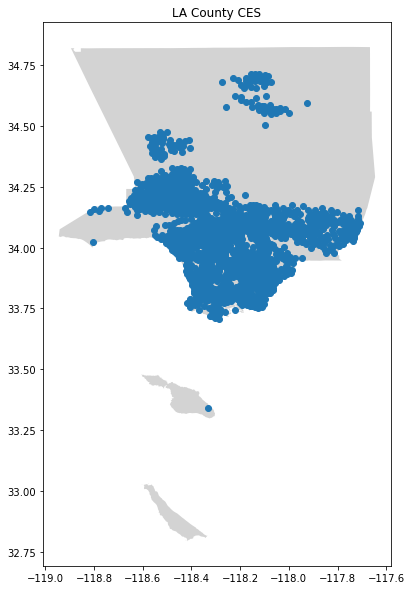

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(ax=ax)
plt.title("LA County CES")

## NASA SoCAB Land Cover